In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import pymc3 as pm

%matplotlib inline

/Users/claus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(A couple of utility plotting functions, scroll down)

In [2]:
def plot_beta(a, b, xlim=None, percent_only=False, ax=None):
    x = np.linspace(0.0, 1.0, 1000)
    if not ax:
        _, ax = plt.subplots()
    f = lambda a, b : stats.beta.pdf(x, a, b)
    y = f(a,b)
    mu = round(stats.beta.mean(a,b), 4)
    if percent_only:
        label=f'{mu:.2%}'
    else:
        label=r'$\alpha$={0}, $\beta$={1}, $\mu$={2}'.format(int(a),int(b),mu)
    plot_pdf = lambda a, b : ax.plot(x, y, label=label)

    plot_pdf(a, b)
    plt.legend(loc='upper right', frameon=False)
    if xlim:
        ax.set(xlim=xlim, xlabel='x', ylabel='f(x)')
#     plt.show()

In [19]:
def plot_binomial(n, p, xlim=None, ax=None):

    x = range(0, n+1, 1)
    if not ax:
        _, ax = plt.subplots()
    f = lambda a, b : stats.binom.pmf(x, n=n, p=p)
    y = f(n,p)
    ax.bar(x, y, label=f'n={n}, p={p}')
    plt.legend(loc='best', frameon=False)
    ax.set_xticks(np.arange(len(x)))
    if xlim:
        ax.set(xlim=xlim, xlabel='x', ylabel='f(x)')
    plt.show()

In [20]:
def plot_poisson(mu, xlim=None):

    x = np.arange( stats.poisson.ppf(0.01, mu), stats.poisson.ppf(0.99, mu))
    fig, ax = plt.subplots()
    y = stats.poisson.pmf(x, mu)

    ax.bar(x, y, label=f'$mu$={mu:,}') 
#                                      label=r'$\alpha$={0}, $\beta$={1}, $\mu$={2}'.format(int(a),int(b),mu))

    plt.legend(loc='upper right', frameon=False)
    if xlim:
        ax.set(xlim=xlim, xlabel='x', ylabel='f(x)')
    plt.show()

If we think of a fair coin as having probability of coming up heads at 50%, does observing 8 heads in 10 additional flips change our mind of the fairness of the coin?
In other words, is observing 8/10 heads enough data to overwhelm our prior belief in fairness?

To start, we plot a $beta$ distribution of the probability of a fair coin (with $\alpha=1000$ and $\beta=1000$) representing our fairly strong prior belief in a 50% chance:

$p_{fair} \sim Beta(1000, 1000)$

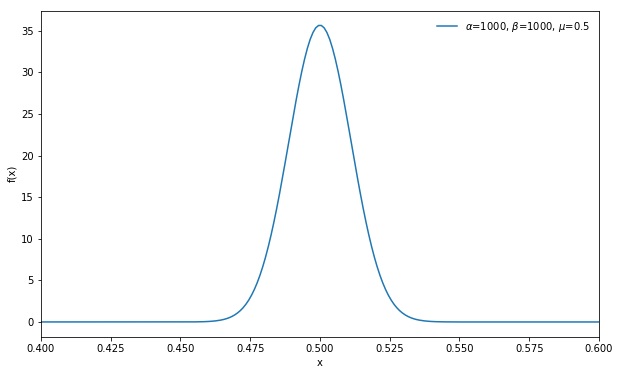

In [21]:
_, ax = plt.subplots(figsize=(10,6))
# plot_beta(1000,1000, ax=ax)
plot_beta(1000,1000, ax=ax, xlim=[.4,.6])

Let's look at the binomial distribution of a fair coin after 10 flips:

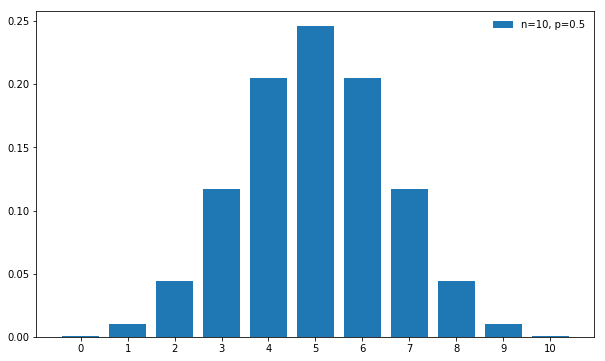

In [22]:
_, ax = plt.subplots(figsize=(10,6))
plot_binomial(10, 0.5, ax=ax)

Looks like 8 is within bounds.

Here's a look at a couple of a different fair coin probability $beta$ distributions with different levels of certainty:

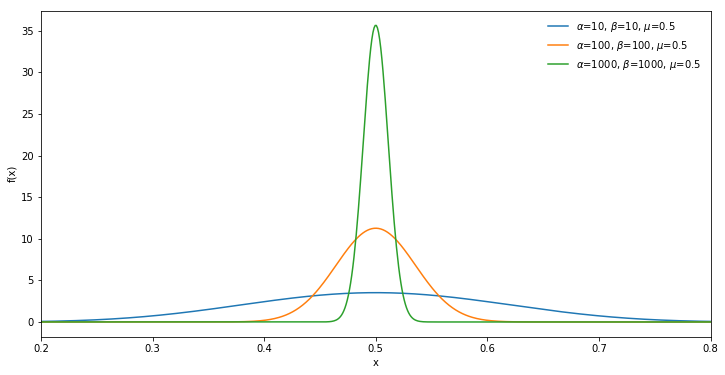

In [23]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_beta(10,10, [0.2, 0.8], ax=ax)
plot_beta(100,100, ax=ax)
plot_beta(1000,1000, ax=ax)

Let's set up a $Beta-Binomial$ model for coin flips for different number of flips, from 10 to 1000 and different number of observed heads from 8 to 800:

In [29]:
n_samples = 10000
n_burn = int(n_samples/2)
a = 1000.0
b = 1000.0
n = np.array([10, 100, 1000])
data = np.array([8, 80, 800])

In [32]:
coins_flips = np.arange(0, len(n))

In [45]:
with pm.Model() as coin_model:

    coin_bias = pm.Beta('bias', alpha=a, beta=b, shape=len(n))

    heads = pm.Binomial('heads', n=n, 
                                 p=coin_bias[coins_flips], 
                                 observed=data
                       )

    trace = pm.sample(n_samples, tune=n_burn, progressbar=True, njobs=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias_logodds__]
100%|██████████| 15000/15000 [00:15<00:00, 944.55it/s] 


In [ ]:
pm.traceplot(trace);

In [47]:
# with coin_model:
#     ppc = pm.sample_ppc(trace)

If we plot our posterior belief after 10, 100, and 1000 flips, with 8, 80 and 800 observed heads, respectively, we see how each additional set of flips (data) starts to move our posterior away from our prior belief. However, so far, we're not yet convinced this is really an 80% heads coin.

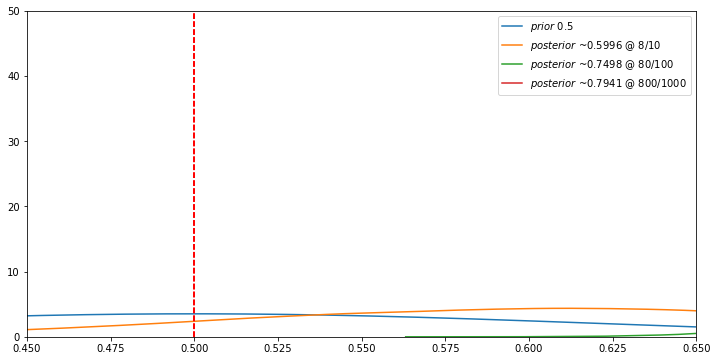

In [48]:
# f, ax = plt.subplots(len(n), 1, figsize=(10, len(n)*4), sharex=True, )
dt = trace.get_values('bias')

f, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.linspace(0.0, 1.0, 1000)
y = stats.beta.pdf(x, a, b)
mu = round(stats.beta.mean(a,b), 4)
ax.plot(x, y, label=f'$prior$ {mu}')

for i, d in enumerate(zip(data, n)):
    h, f = d
    t = [t[i] for t in dt]
    m = np.mean(t)
    sns.distplot(t, kde=True, hist=False, ax=ax, norm_hist=True, label=f'$posterior$ ~{m:.4f} @ {h}/{f}')
    ax.axvline(0.5, color='r', linestyle='dashed')
    ax.set_xlim(0.45, 0.65)
    ax.set_ylim(0., 50)
    ax.legend(loc='best')
    
plt.show()

But, what if we're not that confident in our choice of prior and we're not that sure that this is a fair coin? Let's model this with a weak prior:

$p_{fair} \sim Beta(10, 10)$

In [40]:
n_samples = 10000
n_burn = int(n_samples/2)
a = 10.0
b = 10.0
n = [10, 100, 1000]
data = [8, 80, 800]
coins_flips = np.arange(0, len(n))

with pm.Model() as coin_model_weak:

    coin_bias = pm.Beta('bias', alpha=a, beta=b, shape=len(n))

    heads = pm.Binomial('heads', n=n, 
                                 p=coin_bias[coins_flips], 
                                 observed=data
                       )

    trace = pm.sample(n_samples, tune=n_burn, progressbar=True, njobs=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias_logodds__]
100%|██████████| 15000/15000 [00:13<00:00, 1103.11it/s]


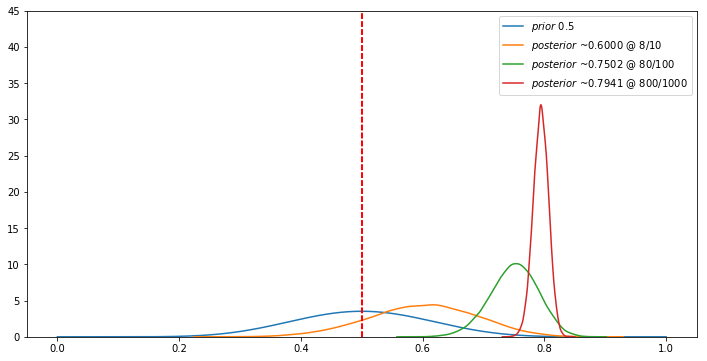

In [41]:
dt = trace.get_values('bias')

f, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.linspace(0.0, 1.0, 1000)
y = stats.beta.pdf(x, a, b)
mu = round(stats.beta.mean(a,b), 4)
ax.plot(x, y, label=f'$prior$ {mu}')

for i, d in enumerate(zip(data, n)):
    h, f = d
    t = [t[i] for t in dt]
    m = np.mean(t)
    sns.distplot(t, kde=True, hist=False, ax=ax, norm_hist=True, label=f'$posterior$ ~{m:.4f} @ {h}/{f}')
    ax.axvline(0.5, color='r', linestyle='dashed')
    ax.set_ylim(0., 45)
    ax.legend(loc='best')
plt.show()

After 1000 additional flips (vs our prior 10), we've completely overwhelmed our prior belief in 50%.

In [ ]:
# plot_beta(700,300, [0.5, 0.85], percent_only=True)
# plot_beta(15,100, [0., 0.35], percent_only=True)
# plot_beta(25,75, [0., 0.5], percent_only=True)
# plot_beta(30,70, [0., 0.99], percent_only=True)
# plot_beta(100,100, [0.4, 0.6])
# plot_beta(1000,1000, [0.4, 0.6])